In [2]:
import pandas as pd
from collections import Counter
from src.datasets.clinvar import load_clinvar
from sklearn.model_selection import train_test_split

# Source rationale 
GENE_SOURCE = "PMID: 27760307 (osteosarcoma somatic mutation studies)"

GENE_SET = {
    "TP53","RB1","RECQL4","BLM","WRN","ATRX","BAP1","RET","MUTYH",
    "ATM","PTEN","NUMA1","MDC1","CDK4","MDM2","MYC","CARD11","EGFR",
    "GNAQ","GNAS","JAK1","MAML2","FBXW7","ALK","PDGFRA","PDGFRB","PIK3CA",
    "APC","CTNND1","CCNE1","COPS3","PDPK1","AKT1","E1F4B","NOTCH1",
    "NOTCH2","NOTCH3","NOTCH4","PRKCA","EP300","SMAD4","RUNX1","ARID1A",
    "BRCA1","BRCA2","MLH1","CBL","PTCH1","NF1","MAP2K4","AKT2","PIK3R1",
    "TSC2","GAS7","MLLT3","DLG2","VHL"
}

# Label policy 
POS_LABELS = {"Pathogenic", "Likely_pathogenic", "Pathogenic/Likely_pathogenic"}
NEG_LABELS = {"Benign", "Likely_benign", "Benign/Likely_benign"}

def parse_geneinfo(val):
    """Parse ClinVar GENEINFO field like 'TP53:7157|RB1:5925' -> ['TP53','RB1']."""
    if val in ("NA", None):
        return []
    return [entry.split(":")[0] for entry in str(val).split("|") if entry]

def parse_label(val):
    """Normalize CLNSIG to a single label; if multiple are provided, take the first."""
    if isinstance(val, list):
        return val[0] if len(val) > 0 else "NA"
    return val if val is not None else "NA"

# Load ClinVar 
records = load_clinvar.read_vcf(
    vcf_file_path="root/data/clinvar_20240416.vcf",
    all_records=True
)

total_records = len(records)
gene_pass = 0
label_pass = 0
label_counts_gene_filtered = Counter()
rows = []

for r in records:
    genes = parse_geneinfo(r.get("GENEINFO", ""))
    if not genes or not (set(genes) & GENE_SET):
        continue
    gene_pass += 1

    label_raw = parse_label(r.get("CLNSIG", "NA"))
    label_counts_gene_filtered[label_raw] += 1

    if label_raw not in (POS_LABELS | NEG_LABELS):
        continue
    label_pass += 1

    alt = r.get("Alternate Base", [])
    alt_base = alt[0] if isinstance(alt, list) and len(alt) > 0 else alt

    rows.append({
        "chrom": r["Chromosome"],
        "pos": r["Position"],
        "ref_base": r["Reference Base"],
        "alt_base": alt_base,
        "variant_type": r.get("CLNVC", "NA"),
        "genes": genes,
        "label_raw": label_raw
    })

df = pd.DataFrame(rows)
df["label_bin"] = df["label_raw"].map(lambda x: 1 if x in POS_LABELS else 0).astype(int)

# Metrics 
print("GENE SET SOURCE:", GENE_SOURCE)
print("GENE SET SIZE:", len(GENE_SET))
print("POSITIVE LABELS:", POS_LABELS)
print("NEGATIVE LABELS:", NEG_LABELS)

print("\nCounts:")
print("Total ClinVar records:", total_records)
print("After gene filter:", gene_pass)
print("After label filter:", label_pass)

print("\nLabel distribution AFTER gene filter (before label drop):")
print(pd.Series(label_counts_gene_filtered).sort_values(ascending=False).head(15))

print("\nFinal label distribution (kept):")
print(df["label_raw"].value_counts())

# Train/Val split 
df_train, df_val = train_test_split(
    df, test_size=0.2, stratify=df["label_bin"], random_state=42
)
print("\nTrain counts:", df_train["label_bin"].value_counts().to_dict())
print("Val counts (original distribution preserved):", df_val["label_bin"].value_counts().to_dict())

# Imbalance handling: CLASS_WEIGHTS will be  changed in case of classes imbalance in data
IMBALANCE_STRATEGY = "class_weights"  
CLASS_WEIGHTS = (1.0, 1.0)
print("\nImbalance handling:", IMBALANCE_STRATEGY, "weights:", CLASS_WEIGHTS)

GENE SET SOURCE: PMID: 27760307 (osteosarcoma somatic mutation studies)
GENE SET SIZE: 57
POSITIVE LABELS: {'Likely_pathogenic', 'Pathogenic', 'Pathogenic/Likely_pathogenic'}
NEGATIVE LABELS: {'Likely_benign', 'Benign', 'Benign/Likely_benign'}

Counts:
Total ClinVar records: 2728246
After gene filter: 164057
After label filter: 80334

Label distribution AFTER gene filter (before label drop):
Uncertain_significance                          64353
Likely_benign                                   43748
Pathogenic                                      22015
Conflicting_classifications_of_pathogenicity    15140
Benign                                           5491
Likely_pathogenic                                3870
not_provided                                     3211
Benign/Likely_benign                             2838
Pathogenic/Likely_pathogenic                     2372
other                                             895
drug_response                                      57
no_classifi

In [3]:
# Import the genome sequence extractor utility used to pull reference/alternate sequences.
from src.sequence_extractor import GenomeSequenceExtractor

# Fixed context window length (number of bases) to extract around each variant.
SEQ_LEN = 512  

# Initialize the extractor
extractor = GenomeSequenceExtractor(fasta_file="root/data/hg38.fa")

# Calculate gc content which could serve for checking label distribution 
# or to keep similar GC distributions across train/val to reduce covariate shift
# It could also be used to as an extra scalar feature to the classifier head 
# (but we won't have time to normalize for gc content or use it as a feature) 
def gc_content(seq):
    seq = seq.upper()
    gc = sum(b in "GC" for b in seq if b != "N")
    denom = sum(b in "ACGT" for b in seq)
    return gc/denom if denom else 0.0

# Build context ref and alt sequences of length SEQ_LEN
contexts = []
for _, row in df.iterrows():
    record = {
        "Chromosome": row.chrom,
        "Position": int(row.pos),
        "Reference Base": row.ref_base,
        "Alternate Base": [row.alt_base],
        "ID": f"{row.chrom}_{row.pos}"
    }
    ref_seq, alt_seq = extractor.extract_sequence_from_record(record, sequence_length=SEQ_LEN)
    contexts.append((ref_seq, alt_seq, gc_content(ref_seq)))

df[["context_ref","context_alt","gc_ref"]] = pd.DataFrame(contexts, index=df.index)

# Quick sanity
print(df.head())


  chrom       pos                     ref_base alt_base  \
0     1  26695829                            G        A   
1     1  26695894                            T        C   
2     1  26696377                            C        T   
3     1  26696421  CCCCGCCGCCGCCAGCAGCCTGGGCAA        C   
4     1  26696427                            C        G   

                variant_type     genes      label_raw  label_bin  \
0  single_nucleotide_variant  [ARID1A]  Likely_benign          0   
1  single_nucleotide_variant  [ARID1A]  Likely_benign          0   
2  single_nucleotide_variant  [ARID1A]         Benign          0   
3                   Deletion  [ARID1A]     Pathogenic          1   
4  single_nucleotide_variant  [ARID1A]  Likely_benign          0   

                                         context_ref  \
0  GAAAGCGGCTGAGGGCCTGCCGCCGCCGCGGCTTGTTCTCTCCCCT...   
1  GGAGCGAGTCCGTTCCACGGCCTGCGCCCGCTCCGCTCTCCACTCC...   
2  AGCCGGGAGAGCCGGGTCCCGAGCCTACAGAGCCGGGAGCAGCTGA...   
3  GAGCCGCCG

In [4]:
# Normalize raw labels to string
label = df["label_raw"].astype(str)

# Define which ClinVar labels we will treat as positive/negative
patho = {"Pathogenic", "Likely_pathogenic", "Pathogenic/Likely_pathogenic"}
beni  = {"Benign", "Likely_benign", "Benign/Likely_benign"}

# Keep only records with patho or beni labels 
# Remove VUS and such labels
df = df[label.isin(patho | beni)].copy()
df["label_bin"] = df["label_raw"].map(lambda x: "pathogenic" if x in patho else "benign")

# Quick check: how many pathogenic vs benign after filtering
print(df["label_bin"].value_counts())

# Inspect how the original ClinVar labels contributed to the final dataset
df["label_raw"].value_counts().rename_axis("label_raw").reset_index(name="count")

label_bin
benign        52077
pathogenic    28257
Name: count, dtype: int64


,label_raw,count
0,Likely_benign,43748
1,Pathogenic,22015
2,Benign,5491
3,Likely_pathogenic,3870
4,Benign/Likely_benign,2838
5,Pathogenic/Likely_pathogenic,2372


In [5]:
# Reload and test
import torch
import torch.nn.functional as F
import os, json, math, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForMaskedLM

# Config 
MODEL_ID = "InstaDeepAI/nucleotide-transformer-v2-500m-multi-species"
CACHE_DIR = "D:/hf-cache-ntv2-clean"
OUT_DIR = "D:/genomic-FM"

USE_CLASS_WEIGHTS = True
CLASS_WEIGHTS = (1.0, 1.8)  # keep weights enabled (because data is imbalanced)
MAX_LEN = 512
USE_AMP = True
ATTN_IMPL = "eager" # keeps attention weights for interpretability
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_WORKERS = 0 
TRAIN_BS = 4 
VAL_BS = 16
SEED = 42
# Seed all RNGs for reproducibility
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)


# Dataset: tokenized ref/alt pairs + label
class VariantDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=512):
        self.df = df.reset_index(drop=True)
        self.tok = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)
    
    # Pull row and tokenize reference and alternate contexts    
    def __getitem__(self, i):
        row = self.df.iloc[i]
        enc_ref = self.tok(row["context_ref"], return_tensors="pt",
                           padding="max_length", truncation=True, max_length=self.max_len)
        enc_alt = self.tok(row["context_alt"], return_tensors="pt",
                           padding="max_length", truncation=True, max_length=self.max_len)
        return {
            "input_ids_ref": enc_ref["input_ids"].squeeze(0),
            "attention_mask_ref": enc_ref["attention_mask"].squeeze(0),
            "input_ids_alt": enc_alt["input_ids"].squeeze(0),
            "attention_mask_alt": enc_alt["attention_mask"].squeeze(0),
            "label": torch.tensor(int(row["label_bin"]), dtype=torch.long),
            "idx": torch.tensor(int(i), dtype=torch.long),  # <-- add this
        }
# Model: NTv2 encoder + delta head
class NTDeltaClassifier(nn.Module):
    def __init__(self, backbone, hidden=512):
        super().__init__()
        self.backbone = backbone
        d = backbone.config.hidden_size
        # Small MLP head on top of delta embedding
        self.head = nn.Sequential(nn.Linear(d, hidden), nn.ReLU(), nn.Linear(hidden, 2))
    # Compute mean over non-padding tokens
    @staticmethod
    def masked_mean_pool(last_hidden_state, attention_mask):
        mask = attention_mask.unsqueeze(-1).float()
        summed = (last_hidden_state * mask).sum(dim=1)
        denom = mask.sum(dim=1).clamp(min=1.0)
        return summed / denom

    def encode(self, input_ids, attention_mask, output_attentions=False, output_hidden_states=False):
        return self.backbone(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=True,
        )

    def forward(self, input_ids_ref, input_ids_alt, attention_mask_ref, attention_mask_alt,
                return_backbone=False, output_attentions=False, output_hidden_states=False):
        # Encode ref and alt sequences separately
        ref_out = self.encode(input_ids_ref, attention_mask_ref,
                              output_attentions=output_attentions,
                              output_hidden_states=output_hidden_states)
        alt_out = self.encode(input_ids_alt, attention_mask_alt,
                              output_attentions=output_attentions,
                              output_hidden_states=output_hidden_states)
         # Pool token embeddings to per-sequence vectors
        h_ref = self.masked_mean_pool(ref_out.last_hidden_state, attention_mask_ref)
        h_alt = self.masked_mean_pool(alt_out.last_hidden_state, attention_mask_alt)
        h = h_alt - h_ref
        logits = self.head(h)
        if return_backbone:
            return logits, ref_out, alt_out
        return logits

def load_tokenizer_and_backbone(model_id, cache_dir, device):
    # Load tokenizer from HF cache
    tok = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True, cache_dir=cache_dir)
    # Load full MLM model
    mlm = AutoModelForMaskedLM.from_pretrained(
        model_id,
        trust_remote_code=True,
        cache_dir=cache_dir,
        attn_implementation=ATTN_IMPL,
    )

    backbone = mlm.esm  # correct encoder for NTv2
    
    # Save VRAM by deleting mlm head as we do not want mlm predictions
    
    del mlm
    
    backbone.to(device)
    
    print("Backbone config:",
          backbone.config.hidden_size,
          backbone.config.num_hidden_layers,
          backbone.config.num_attention_heads)
    return tok, backbone

tok, backbone = load_tokenizer_and_backbone(MODEL_ID, CACHE_DIR, DEVICE)

# Prepare data

# Ensure label_bin is 0/1
if df["label_bin"].dtype == object:
    df["label_bin"] = (df["label_bin"] == "pathogenic").astype(int)
else:
    df["label_bin"] = df["label_bin"].astype(int)

df_train, df_val = train_test_split(df, test_size=0.2, stratify=df["label_bin"], random_state=SEED)

train_ds = VariantDataset(df_train, tok, max_len=MAX_LEN)
val_ds   = VariantDataset(df_val, tok, max_len=MAX_LEN)

train_loader = DataLoader(train_ds, batch_size=TRAIN_BS, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=VAL_BS, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

model = NTDeltaClassifier(backbone).to(DEVICE)
model.load_state_dict(torch.load("d:/genomic-FM/model_ref_alt_state_dict.pt", map_location=DEVICE), strict=True)
model.eval()

batch = next(iter(val_loader))

with torch.inference_mode():
    logits = model(
        input_ids_ref=batch["input_ids_ref"].to(DEVICE),
        input_ids_alt=batch["input_ids_alt"].to(DEVICE),
        attention_mask_ref=batch["attention_mask_ref"].to(DEVICE),
        attention_mask_alt=batch["attention_mask_alt"].to(DEVICE),
    )
    probs = torch.softmax(logits, dim=1)[:, 1]
    y_pred = logits.argmax(dim=1)

print("logits NaN?", torch.isnan(logits).any().item())
print("probs  NaN?", torch.isnan(probs).any().item())

Backbone config: 1024 29 16


C:\Users\Sarah's PC\AppData\Local\Temp\ipykernel_9244\1667628502.py:154: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("d:/genomic-FM/model_

logits NaN? False
probs  NaN? False


TP selected: idx=191 (skipped 6 prior matches; scanned=192)


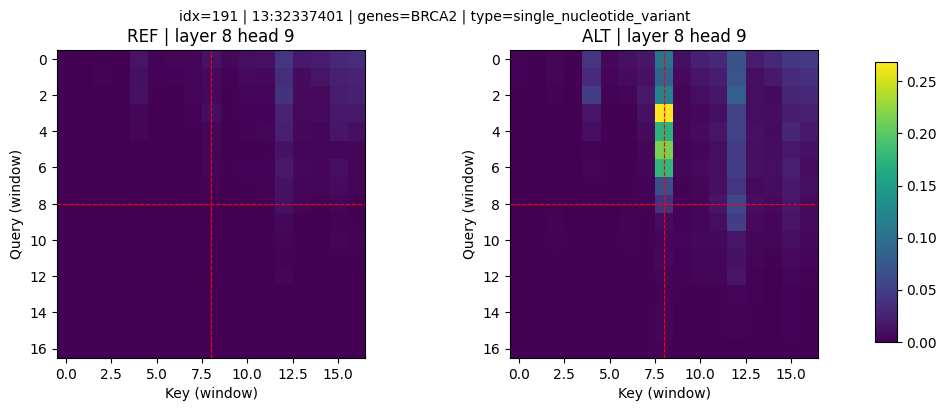

idx=191  layer=8 head=9
Variant token span: [43,43] (center=43)  window=[13,74)

REF tokens (variant tokens bracketed):
GAACAA AAATAG TGTAAA GCAGCA TATAAA AATGAC TCTAGG TCAAGA TTTAAA ATCGGA CATCTC CTTGAA TATAGA TAAAAT ACCAGA AAAAAA TAATGA TTACAT GAACAA ATGGGC AGGACT CTTAGG TCCAAT TTCAAA TCACAG TTTTGG AGGTAG CTTCAG AACAGC TTCAAA [TAAGGA] AATCAA GCTCTC TGAACA TAACAT TAAGAA GAGCAA AATGTT CTTCAA AGATAT TGAAGA ACAATA TCCTAC TAGTTT AGCTTG TGTTGA AATTGT AAATAC CTTGGC ATTAGA TAATCA AAAGAA ACTGAG CAAGCC TCAGTC AATTAA TACTGT ATCTGC ACATTT ACAGAG TAGTGT

ALT tokens (variant tokens bracketed):
GAACAA AAATAG TGTAAA GCAGCA TATAAA AATGAC TCTAGG TCAAGA TTTAAA ATCGGA CATCTC CTTGAA TATAGA TAAAAT ACCAGA AAAAAA TAATGA TTACAT GAACAA ATGGGC AGGACT CTTAGG TCCAAT TTCAAA TCACAG TTTTGG AGGTAG CTTCAG AACAGC TTCAAA [TAAGTA] AATCAA GCTCTC TGAACA TAACAT TAAGAA GAGCAA AATGTT CTTCAA AGATAT TGAAGA ACAATA TCCTAC TAGTTT AGCTTG TGTTGA AATTGT AAATAC CTTGGC ATTAGA TAATCA AAAGAA ACTGAG CAAGCC TCAGTC AATTAA TACTGT ATCTGC ACA

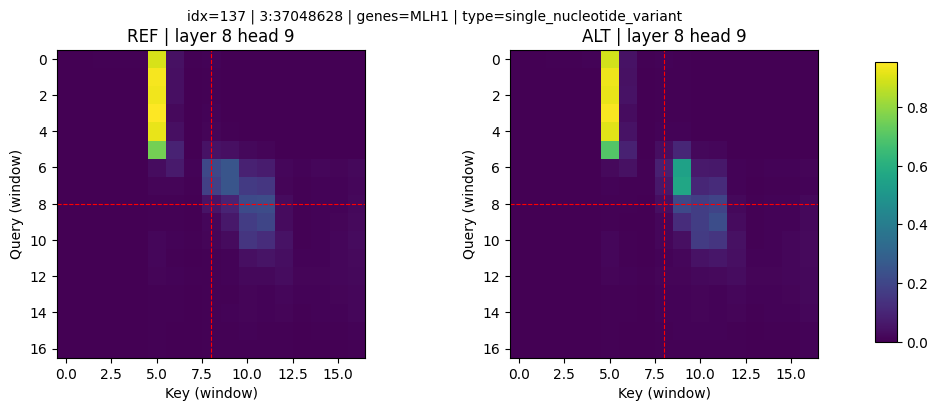

idx=137  layer=8 head=9
Variant token span: [43,43] (center=43)  window=[13,74)

REF tokens (variant tokens bracketed):
ACTGGA GAAATG GGATTT GTTTAA ACTATG ACAGCA TTATTT CTTGTT CCCTTG TCCTTT TTCCTG CAAGCA GGAAGG GAACCT GATTGG ATTACC CCTTCT GATTGA CAACTA TGTGCC CCCTTT GGAGGG ACTGCC TATCTT CATTCT TCGACT AGCCAC TGAGGT CAGTGA TCAAGC [AGATAC] TAAGCA TTTCGG TACATG CATGTG TGCTGG AGGGAA AGGGCA AATGAC CACCCT TTGATC TGGAAT GATAAA GATGAT AAGGGT GGGATA GCTGAA GGCCTG CTCTCA TCCCCA CTAATA TTCATT CCCAGC AATATT CAGCAG TCCCAT TTACAG TTTTAA CGCCTA AAGTAT CACATT

ALT tokens (variant tokens bracketed):
ACTGGA GAAATG GGATTT GTTTAA ACTATG ACAGCA TTATTT CTTGTT CCCTTG TCCTTT TTCCTG CAAGCA GGAAGG GAACCT GATTGG ATTACC CCTTCT GATTGA CAACTA TGTGCC CCCTTT GGAGGG ACTGCC TATCTT CATTCT TCGACT AGCCAC TGAGGT CAGTGA TCAAGC [AGATGC] TAAGCA TTTCGG TACATG CATGTG TGCTGG AGGGAA AGGGCA AATGAC CACCCT TTGATC TGGAAT GATAAA GATGAT AAGGGT GGGATA GCTGAA GGCCTG CTCTCA TCCCCA CTAATA TTCATT CCCAGC AATATT CAGCAG TCCCAT TTACAG TTTTAA CGC

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# CONFIG
LAYER = 8
HEAD  = 9
TOP_K = 3
MARGIN = 8                 # query window for Δmass computation (hit test)
PLOT_MARGIN = 8            # heatmap window around variant
WINDOW_TOK = 30            # token window radius to print around variant center

REQUIRE_HIT = True         # require target head is in top_k by |Δmass|
PRED_LABEL_TP = 1
PRED_LABEL_TN = 0

MAX_SCAN = 5000            # cap for speed
SKIP_TP = 6                # pick the TP example AFTER skipping 6 matches
SKIP_TN = 6                # same idea for TN

device = next(model.parameters()).device
model.eval()
backbone = model.backbone

# Helper functions
@torch.no_grad()
def get_attentions(input_ids, attention_mask):
    out = backbone(
        input_ids=input_ids,
        attention_mask=attention_mask,
        output_attentions=True,
        return_dict=True,
    )
    atts = getattr(out, "attentions", None)
    if atts is None:
        raise RuntimeError("No attentions returned. Ensure backbone uses attn_implementation='eager'.")
    return atts 

def is_snv(vt):
    return str(vt).lower() == "single_nucleotide_variant"

def variant_token_positions(ref_ids, alt_ids):
    return (ref_ids != alt_ids).squeeze(0).nonzero(as_tuple=False).squeeze(1)

def attention_mass_to_variant(attn_hss, q_idx, k_idx):
    return attn_hss[:, q_idx][:, :, k_idx].sum(dim=(1, 2))  # (H,)

def _safe_get(row, key, default="NA"):
    try:
        v = row.get(key, default)
        return default if v is None else v
    except Exception:
        return default

def _fmt_genes(g):
    if g is None:
        return "NA"
    if isinstance(g, (list, tuple, np.ndarray)):
        return ",".join([str(x) for x in g]) if len(g) else "NA"
    return str(g)

def _resolve_layer(attentions, layer_idx):
    return layer_idx if layer_idx >= 0 else (len(attentions) + layer_idx)

@torch.no_grad()
def head_is_hit_for_example(ref_ids, alt_ids, ref_mask, alt_mask,
                            layer_idx, head_idx, top_k=3, margin=8):
    diff_idx = variant_token_positions(ref_ids, alt_ids)
    if diff_idx.numel() == 0:
        return False

    dmin, dmax = int(diff_idx.min().item()), int(diff_idx.max().item())
    lo = max(0, dmin - margin)
    hi = min(ref_ids.shape[1], dmax + margin + 1)
    q_idx = torch.arange(lo, hi, device=ref_ids.device)

    ref_atts = get_attentions(ref_ids, ref_mask)
    alt_atts = get_attentions(alt_ids, alt_mask)
    li = _resolve_layer(ref_atts, layer_idx)

    ref_attn = ref_atts[li].squeeze(0)  # (H,S,S)
    alt_attn = alt_atts[li].squeeze(0)

    mass_ref = attention_mass_to_variant(ref_attn, q_idx, diff_idx)
    mass_alt = attention_mass_to_variant(alt_attn, q_idx, diff_idx)
    abs_delta = (mass_alt - mass_ref).abs()

    kk = min(top_k, abs_delta.numel())
    top_heads = torch.topk(abs_delta, k=kk).indices.tolist()
    return int(head_idx) in top_heads

def format_token_window(ref_ids, alt_ids, diff_idx, window=30):
    S = ref_ids.shape[1]
    center = int(torch.round(diff_idx.float().mean()).item())
    start = max(0, center - window)
    end = min(S, center + window + 1)

    ref_slice = ref_ids[0, start:end].detach().cpu().tolist()
    alt_slice = alt_ids[0, start:end].detach().cpu().tolist()

    ref_toks = tok.convert_ids_to_tokens(ref_slice)
    alt_toks = tok.convert_ids_to_tokens(alt_slice)

    diff_set = set(int(x) for x in diff_idx.detach().cpu().tolist())

    def mark(tokens, offset):
        out = []
        for j, t in enumerate(tokens):
            if (offset + j) in diff_set:
                out.append(f"[{t}]")
            else:
                out.append(t)
        return " ".join(out)

    return {
        "center": center,
        "start": start,
        "end": end,
        "ref_tok_str": mark(ref_toks, start),
        "alt_tok_str": mark(alt_toks, start),
    }

def plot_one_head_ref_alt_with_meta(ref_ids, alt_ids, ref_mask, alt_mask,
                                    idx, layer_idx, head_idx,
                                    plot_margin=8):
    diff_idx = variant_token_positions(ref_ids, alt_ids)
    if diff_idx.numel() == 0:
        print("No token diffs; skipping plot.")
        return

    row = val_ds.df.iloc[int(idx)]
    chrom = _safe_get(row, "chrom", "NA")
    pos   = _safe_get(row, "pos", "NA")
    genes = _fmt_genes(_safe_get(row, "genes", "NA"))
    vt    = _safe_get(row, "variant_type", "NA")
    ref_allele = _safe_get(row, "ref", "")
    alt_allele = _safe_get(row, "alt", "")

    ref_atts = get_attentions(ref_ids, ref_mask)
    alt_atts = get_attentions(alt_ids, alt_mask)
    li = _resolve_layer(ref_atts, layer_idx)

    Aref = ref_atts[li].squeeze(0)[head_idx]  # (S,S)
    Aalt = alt_atts[li].squeeze(0)[head_idx]

    dmin, dmax = int(diff_idx.min().item()), int(diff_idx.max().item())
    lo = max(0, dmin - plot_margin)
    hi = min(ref_ids.shape[1], dmax + plot_margin + 1)

    ref_w = Aref[lo:hi, lo:hi].detach().cpu().numpy()
    alt_w = Aalt[lo:hi, lo:hi].detach().cpu().numpy()
    vmax = float(max(ref_w.max(), alt_w.max()))

    fig, axs = plt.subplots(1, 2, figsize=(11, 4))
    im0 = axs[0].imshow(ref_w, cmap="viridis", vmin=0, vmax=vmax)
    im1 = axs[1].imshow(alt_w, cmap="viridis", vmin=0, vmax=vmax)

    for ax, title in [(axs[0], "REF"), (axs[1], "ALT")]:
        for d in diff_idx.detach().cpu().tolist():
            d = int(d)
            if lo <= d < hi:
                ax.axvline(d - lo, color="red", linestyle="--", linewidth=0.8)
                ax.axhline(d - lo, color="red", linestyle="--", linewidth=0.8)
        ax.axvspan(dmin - lo, dmax - lo, color="red", alpha=0.08)
        ax.axhspan(dmin - lo, dmax - lo, color="red", alpha=0.08)
        ax.set_title(f"{title} | layer {li} head {head_idx}")
        ax.set_xlabel("Key (window)")
        ax.set_ylabel("Query (window)")

    # Dedicated side colorbar
    fig.subplots_adjust(right=0.88)
    cax = fig.add_axes([0.90, 0.15, 0.02, 0.70])
    fig.colorbar(im1, cax=cax)

    sup = (
        f"idx={idx} | {chrom}:{pos} | genes={genes} | type={vt}"
        + (f" | {ref_allele}>{alt_allele}" if (ref_allele or alt_allele) else "")
    )
    fig.suptitle(sup, fontsize=10)
    plt.show()

    w = format_token_window(ref_ids, alt_ids, diff_idx, window=WINDOW_TOK)
    print(f"idx={idx}  layer={li} head={head_idx}")
    print(f"Variant token span: [{dmin},{dmax}] (center={w['center']})  window=[{w['start']},{w['end']})")
    print("\nREF tokens (variant tokens bracketed):")
    print(w["ref_tok_str"])
    print("\nALT tokens (variant tokens bracketed):")
    print(w["alt_tok_str"])
    print()

def find_snv_example_after_skips(
    val_loader, val_ds,
    label_value,
    layer_idx, head_idx,
    require_hit=True, top_k=3, margin=8,
    skip_n=0,
    max_scan=5000,
):
    """
    Deterministic selection:
      iterate through matches in data order, skip first skip_n matches, return next one.
    """
    matches_seen = 0
    scanned = 0

    for batch in val_loader:
        B = int(batch["label"].shape[0])
        for i in range(B):
            if scanned >= max_scan:
                return None
            scanned += 1

            idx = int(batch["idx"][i].item())
            row = val_ds.df.iloc[idx]

            if not is_snv(_safe_get(row, "variant_type", "")): continue
            if int(batch["label"][i].item()) != int(label_value): continue

            # Extract input ids and their attention mask
            ref_ids  = batch["input_ids_ref"][i:i+1].to(device)
            alt_ids  = batch["input_ids_alt"][i:i+1].to(device)
            ref_mask = batch["attention_mask_ref"][i:i+1].to(device)
            alt_mask = batch["attention_mask_alt"][i:i+1].to(device)

            if require_hit:
                ok = head_is_hit_for_example(
                    ref_ids, alt_ids, ref_mask, alt_mask,
                    layer_idx=layer_idx, head_idx=head_idx,
                    top_k=top_k, margin=margin
                )
                if not ok:
                    continue

            if matches_seen < skip_n:
                matches_seen += 1
                continue

            return {
                "idx": idx,
                "ref_ids": ref_ids, "alt_ids": alt_ids,
                "ref_mask": ref_mask, "alt_mask": alt_mask,
                "matches_seen_before": matches_seen,
                "scanned": scanned,
            }

    return None

# pick TP/TN examples after skipping N matches
tp_ex = find_snv_example_after_skips(
    val_loader, val_ds,
    label_value=PRED_LABEL_TP,
    layer_idx=LAYER, head_idx=HEAD,
    require_hit=REQUIRE_HIT,
    top_k=TOP_K, margin=MARGIN,
    skip_n=SKIP_TP,
    max_scan=MAX_SCAN
)

tn_ex = find_snv_example_after_skips(
    val_loader, val_ds,
    label_value=PRED_LABEL_TN,
    layer_idx=LAYER, head_idx=HEAD,
    require_hit=REQUIRE_HIT,
    top_k=TOP_K, margin=MARGIN,
    skip_n=SKIP_TN,
    max_scan=MAX_SCAN
)

if tp_ex is None:
    print(f"No TP SNV example found for (layer={LAYER}, head={HEAD}) after skip_n={SKIP_TP} within max_scan={MAX_SCAN}.")
else:
    print(f"TP selected: idx={tp_ex['idx']} (skipped {SKIP_TP} prior matches; scanned={tp_ex['scanned']})")
    plot_one_head_ref_alt_with_meta(
        tp_ex["ref_ids"], tp_ex["alt_ids"], tp_ex["ref_mask"], tp_ex["alt_mask"],
        idx=tp_ex["idx"],
        layer_idx=LAYER, head_idx=HEAD,
        plot_margin=PLOT_MARGIN
    )

if tn_ex is None:
    print(f"No TN SNV example found for (layer={LAYER}, head={HEAD}) after skip_n={SKIP_TN} within max_scan={MAX_SCAN}.")
else:
    print(f"TN selected: idx={tn_ex['idx']} (skipped {SKIP_TN} prior matches; scanned={tn_ex['scanned']})")
    plot_one_head_ref_alt_with_meta(
        tn_ex["ref_ids"], tn_ex["alt_ids"], tn_ex["ref_mask"], tn_ex["alt_mask"],
        idx=tn_ex["idx"],
        layer_idx=LAYER, head_idx=HEAD,
        plot_margin=PLOT_MARGIN
    )

Patch the layer’s residual stream output (after the attention block)
https://www.neelnanda.io/mechanistic-interpretability/attribution-patching

1. Run clean (REF) input and cache the residual stream at the input of each layer.
2. Run corrupted (ALT) input, and at layer L’s input, replace the residual stream at position P with the cached clean residual.
3. Continue forward through layer L and beyond.
4. Measure the patch effect on the logit (difference vs baseline corrupted run).
5. Repeat for all layers and positions and output a heatmap.

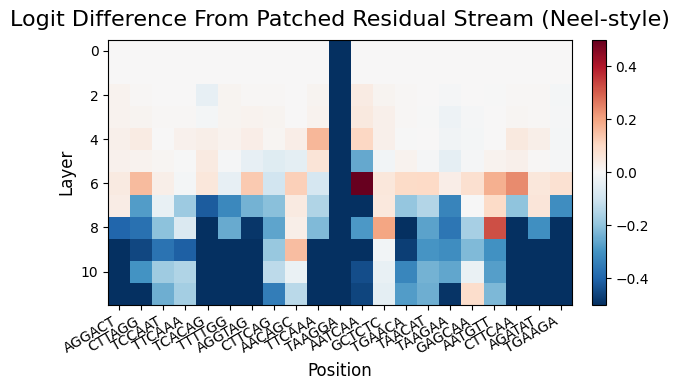

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

device = next(model.parameters()).device
model.eval()
backbone = model.backbone
backbone.eval()

# Pre-set parameters
EXAMPLE_IDX = 191         # idx in val_ds.df
PLOT_MARGIN = 10          # +/- tokens around variant center
LAYERS_TO_PLOT = None     # None -> first 12 layers; or list like [0,1,2,...]
LOGIT_CLASS = 1           # 1 = pathogenic logit

# Helper functions
def get_example_by_idx(val_loader, target_idx):
    for batch in val_loader:
        idxs = batch["idx"].detach().cpu().numpy().astype(int).tolist()
        for i, ix in enumerate(idxs):
            if int(ix) == int(target_idx):
                ex = {}
                for k in ["input_ids_ref","input_ids_alt","attention_mask_ref","attention_mask_alt","label","idx"]:
                    ex[k] = batch[k][i:i+1].to(device)
                return ex
    raise ValueError(f"idx={target_idx} not found.")

def variant_token_positions(ref_ids, alt_ids):
    return (ref_ids != alt_ids).squeeze(0).nonzero(as_tuple=False).squeeze(1)

def get_variant_window(ref_ids, alt_ids, margin=PLOT_MARGIN):
    diff_idx = variant_token_positions(ref_ids, alt_ids)
    if diff_idx.numel() == 0:
        raise RuntimeError("No differing tokens.")
    dmin = int(diff_idx.min().item())
    dmax = int(diff_idx.max().item())
    center = int(torch.round(diff_idx.float().mean()).item())
    lo = max(0, dmin - margin)
    hi = min(ref_ids.shape[1], dmax + margin + 1)
    return diff_idx, dmin, dmax, center, lo, hi

def plot_patching_heatmap(M, pos_labels=None, title="Neel‑style patching"):
    fig, ax = plt.subplots(figsize=(10,4))

    # robust symmetric limits
    #lo = np.nanpercentile(M, 2)
    #hi = np.nanpercentile(M, 98)
    #v = max(abs(lo), abs(hi))
    #if v == 0: v = 1.0

    im = ax.imshow(M, vmin=-0.5, vmax=0.5, cmap="RdBu_r")

    ax.set_title(title, fontsize=16, pad=10)
    ax.set_xlabel("Position", fontsize=12)
    ax.set_ylabel("Layer", fontsize=12)

    if pos_labels is not None:
        ax.set_xticks(range(len(pos_labels)))
        ax.set_xticklabels(pos_labels, rotation=30, ha="right")

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.2)
    fig.colorbar(im, cax=cax)

    fig.tight_layout()
    plt.show()


# Patching logic
if hasattr(backbone, "gradient_checkpointing_disable"):
    backbone.gradient_checkpointing_disable()

@torch.no_grad()
def cache_clean_inputs(ref_ids, ref_mask):
    """
    Cache the residual stream at the INPUT of each layer.
    This matches Neel‑style patching (pre‑attention/MLP).
    """
    cache = []
    hooks = []

    def make_hook():
        def _hook(module, inputs):
            x = inputs[0]  # residual entering layer
            cache.append(x.detach().clone())
        return _hook

    for layer in backbone.encoder.layer:
        hooks.append(layer.register_forward_pre_hook(make_hook()))

    _ = backbone(
        input_ids=ref_ids,
        attention_mask=ref_mask,
        output_hidden_states=False,
        output_attentions=False,
        return_dict=True,
    )

    for h in hooks:
        h.remove()

    return cache  # list of (B,S,D)

@torch.no_grad()
def run_corrupted_with_patch(ref_ids, alt_ids, ref_mask, alt_mask, layer_idx, pos_idx, clean_cache):
    """
    Run model(ref, alt) but patch ONLY the ALT pass (2nd call to backbone).
    """
    hooks = []
    pass_counter = {"n": 0}

    def patch_pre_hook(module, inputs):
        pass_id = pass_counter["n"]
        pass_counter["n"] += 1

        # 0 = REF pass, 1 = ALT pass
        if pass_id != 1:
            return inputs

        x = inputs[0]
        x2 = x.clone()
        x2[:, pos_idx, :] = clean_cache[layer_idx][:, pos_idx, :]
        return (x2,) + tuple(inputs[1:])

    target_layer = backbone.encoder.layer[layer_idx]
    hooks.append(target_layer.register_forward_pre_hook(patch_pre_hook))

    logits = model(
        input_ids_ref=ref_ids,
        input_ids_alt=alt_ids,
        attention_mask_ref=ref_mask,
        attention_mask_alt=alt_mask,
    )

    for h in hooks:
        h.remove()

    return logits


def residual_stream_patching_map_neel(ex, layers_to_plot=None, plot_margin=PLOT_MARGIN, logit_class=1):
    ref_ids  = ex["input_ids_ref"]
    alt_ids  = ex["input_ids_alt"]
    ref_mask = ex["attention_mask_ref"]
    alt_mask = ex["attention_mask_alt"]

    diff_idx, dmin, dmax, center, lo, hi = get_variant_window(ref_ids, alt_ids, margin=plot_margin)

    n_layers = int(backbone.config.num_hidden_layers)
    if layers_to_plot is None:
        layers_to_plot = list(range(0, min(12, n_layers)))
    layers_to_plot = [int(l) for l in layers_to_plot if 0 <= int(l) < n_layers]

    clean_cache = cache_clean_inputs(ref_ids, ref_mask)

    with torch.no_grad():
        base_alt = model(ref_ids, alt_ids, ref_mask, alt_mask)
        base_ref = model(ref_ids, ref_ids, ref_mask, ref_mask)
        base_score = (base_alt[0,1] - base_alt[0,0]) - (base_ref[0,1] - base_ref[0,0])

    W = hi - lo
    M = np.zeros((len(layers_to_plot), W), dtype=np.float32)

    for r, l in enumerate(layers_to_plot):
        for j, pos in enumerate(range(lo, hi)):
            patched_alt = run_corrupted_with_patch(ref_ids, alt_ids, ref_mask, alt_mask, l, [pos], clean_cache)
            patched_score = (patched_alt[0,1] - patched_alt[0,0]) - (base_ref[0,1] - base_ref[0,0])
            M[r, j] = patched_score - base_score

    meta = {"lo": lo, "hi": hi, "layers": layers_to_plot}
    return M, meta

# RUN and PLOT
ex = get_example_by_idx(val_loader, EXAMPLE_IDX)
M, meta = residual_stream_patching_map_neel(ex, layers_to_plot=LAYERS_TO_PLOT, plot_margin=PLOT_MARGIN, logit_class=LOGIT_CLASS)

tokens = tok.convert_ids_to_tokens(ex["input_ids_ref"][0].detach().cpu().tolist())
pos_labels = [tokens[i] for i in range(meta["lo"], meta["hi"])]

plot_patching_heatmap(M, pos_labels=pos_labels,
                      title="Logit Difference From Patched Residual Stream (Neel‑style)")


In the heatmap above:

- Each cell shows how much the logit margin (pathogenic − benign) changes if you patch the clean (REF) residual into the corrupted (ALT) run at that layer (y‑axis) and position (x‑axis).
- Red (positive) means that the patching of that layer/position increases the margin → makes the model more pathogenic‑leaning.
- Blue (negative) means that the patching decreases the margin → makes the model more benign‑leaning.
- White/near zero = patching there has little effect.

It shows: 

- The strong vertical stripe around the variant token positions means that patching the residual at that position is causally important
    - The model's decision margin is causally sensitive to a single localized activation at the variant position, and that activation is sufficient to carry the REF‑like (benign) signal
- The deep blue region in later layers suggests that forcing REF residuals into the ALT run reduces the pathogenic score there → those layers are using ALT‑specific features to push the model toward pathogenic.
- The lighter/near‑zero regions in early layers mean patching early layers doesn’t change the prediction much (or the effect is diffuse).

To conclude:

- If I replace the corrupted ALT residual stream with the clean REF residual at specific layers/positions, the model’s pathogenic‑vs‑benign logit margin changes most strongly at the variant token and in later layers.

Neel Nanda notes attribution patching can be unreliable in residual streams and MLP0 because LayerNorm and embedding‑like discreteness violate linear assumptions. Our heatmap uses true residual stream patching (not attribution), so it directly measures sufficiency and is not subject to those approximation errors. The strong vertical stripe at the variant position thus reflects genuine causal dependence, not a linearization artifact.

However, given our limited Clinvar dataset and training examples differ primarily at the variant token, the model can learn a shortcut that doesn’t reflect biology. That can produce strong, localized patching signals that look mechanistic but are really just overfitting to the synthetic setup. That is due to the following and not limited to:

- The classifier only needs to look at the single mutated position to fit the labels.
- It never needs to model broader context (motifs, splice distance, gene context).
- So patching shows a sharp stripe because the model collapsed the decision onto that token.

We therefore treat the mechanistic results as evidence of sufficiency for the learned decision rule, not proof of biological causality. Further test can be done to test for that by patching outside the variant token. If patching other nearby positions does nothing, the model is overly dependent on the exact variant token. We could also re‑center the variant or shift it and if the patching stripe always appears at the "changed token" it indicates the model uses the change, not biology. 